In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.core import NeuralForecast
from neuralforecast.models import LSTM

from datetime import datetime, timedelta

In [2]:
import plotly.graph_objects as go
import matplotlib.colors as mcolors

In [3]:
from neuralforecast.losses.pytorch import MQLoss
import optuna

In [4]:
class FixedModelLSTMProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        self.dfs = []
        
        self.nf = None
        
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
        
        self.color_mapping = {}
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
        
    
    def create_fixed_model(self, h, freq, model_name, level = [], config = None):
        #Creating AutoLSTM model and predicting with hyperparameter tuning by optuna backend. This is based upon the first training dataframe
        
        
        
        #Checking if model has already been loaded in and fit
        if not self.nf:
            if not level:
                self.nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna", config = config, search_alg = optuna.samplers.TPESampler())], freq = freq)
                self.nf.fit(df = self.dfs[0])
            else:
                self.nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna", loss = MQLoss(level = level), config = config, search_alg = optuna.samplers.TPESampler())], freq = freq)
                self.nf.fit(df = self.dfs[0])
            
            self.nf.save(path=f'AutoLSTM/fixed_models/{model_name}/', overwrite=True)

        for i in range(len(self.dfs)):
            df = self.dfs[i]
            y_hat = self.nf.predict(df = df)

            y_hat.set_index("ds", inplace = True)
            y_hat.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(y_hat)

    
    def load_fixed_model(self, path):
        self.nf = NeuralForecast.load(path = path)
        
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if 'median' in col:
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['median'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    def create_graph(self):
        
        #Create color map for various confidence bands, only if levels are present
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Median gets plotted last
                if "median" in col:
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["median"])))
            
            #Case for if confidence interval not present
            for col in self.forecasts[i].columns:
                if col == "AutoLSTM":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i]["AutoLSTM"], mode = "lines", name = "AutoLSTM"))
            
            
            fig.update_layout(title = f"Fixed Parameter LSTM Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
            
    def calculate_metrics(self):
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def display_maes(self):
        for i in range(len(self.maes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Error for {english_date} model: {self.maes[i]}")
        
    def display_mses(self):
        for i in range(len(self.mses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Squared Error for {english_date} model: {self.mses[i]}")
    
    def display_mapes(self):
        for i in range(len(self.mapes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Percentage Error for {english_date} model: {self.mapes[i]}")
    
    def display_nmses(self):
        for i in range(len(self.nmses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Normalized Mean Square Error for {english_date} model: {self.nmses[i]}")
    
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
        
            
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "AutoLSTM" or "median" in col:
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)

In [23]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [24]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [25]:
Processor = FixedModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [26]:
Processor.create_training_dfs(value_col = "value")

/tmp/ipykernel_645795/1706382660.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_645795/1706382660.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_645795/1706382660.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [27]:
def config_LSTM(trial):
    return {
        "encoder_hidden_size": trial.suggest_categorical("encoder_hidden_size", [100, 200, 300]),
          "encoder_n_layers": trial.suggest_categorical("encoder_n_layers", [1, 2, 3]),
          "context_size": trial.suggest_categorical("context_size", [5, 10, 20, 30, 40, 50]),
          "decoder_hidden_size": trial.suggest_categorical("decoder_hidden_size", [64, 128, 256, 512]),
          "max_steps": 1000,
          "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32, 64]),
          "input_size": trial.suggest_categorical("input_size", [16, 64, 256])
          }

In [28]:
Processor.create_fixed_model(h = 4, freq = "W-SAT", model_name = "test_model", config = config_LSTM)

[I 2025-06-16 22:21:26,912] A new study created in memory with name: no-name-f0ebd24f-b8a6-4505-bf57-ce1cc50ee742
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.8 M  | train
4 | context_adapter | Linear        | 24.1 K | train
5 | mlp_decoder     | MLP           | 1.4 K  | train
----------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.336     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:21:46,105] Trial 0 finished with value: 58.7767219543457 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 20, 'decoder_hidden_size': 64, 'batch_size': 8, 'input_size': 256}. Best is trial 0 with value: 58.7767219543457.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.1 M  | train
4 | context_adapter | Linear        | 36.1 K | train
5 | mlp_decoder     | MLP           | 8.2 K  | train
----------------------------------------------------------
1.1 M  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:21:54,961] Trial 1 finished with value: 242.71530151367188 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 30, 'decoder_hidden_size': 256, 'batch_size': 32, 'input_size': 16}. Best is trial 0 with value: 58.7767219543457.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.1 M  | train
4 | context_adapter | Linear        | 12.0 K | train
5 | mlp_decoder     | MLP           | 3.1 K  | train
----------------------------------------------------------
1.1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:22:10,174] Trial 2 finished with value: 71.02681732177734 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 2, 'context_size': 10, 'decoder_hidden_size': 256, 'batch_size': 8, 'input_size': 256}. Best is trial 0 with value: 58.7767219543457.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 363 K  | train
4 | context_adapter | Linear        | 12.0 K | train
5 | mlp_decoder     | MLP           | 3.1 K  | train
----------------------------------------------------------
378 K

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:22:19,445] Trial 3 finished with value: 168.32656860351562 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 10, 'decoder_hidden_size': 256, 'batch_size': 8, 'input_size': 64}. Best is trial 0 with value: 58.7767219543457.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.8 M  | train
4 | context_adapter | Linear        | 6.0 K  | train
5 | mlp_decoder     | MLP           | 449    | train
----------------------------------------------------------
1.8 M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:22:32,904] Trial 4 finished with value: 90.77781677246094 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 64, 'batch_size': 8, 'input_size': 64}. Best is trial 0 with value: 58.7767219543457.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 1.8 M  | train
4 | context_adapter | Linear        | 60.2 K | train
5 | mlp_decoder     | MLP           | 26.6 K | train
----------------------------------------------------------
1.9 M   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:22:46,359] Trial 5 finished with value: 104.4052734375 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 3, 'context_size': 50, 'decoder_hidden_size': 512, 'batch_size': 64, 'input_size': 64}. Best is trial 0 with value: 58.7767219543457.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 16.1 K | train
5 | mlp_decoder     | MLP           | 11.3 K | train
----------------------------------------------------------
511 K   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:23:01,677] Trial 6 finished with value: 115.9840316772461 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 2, 'context_size': 20, 'decoder_hidden_size': 512, 'batch_size': 8, 'input_size': 256}. Best is trial 0 with value: 58.7767219543457.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 805 K  | train
4 | context_adapter | Linear        | 4.0 K  | train
5 | mlp_decoder     | MLP           | 897    | train
----------------------------------------------------------
810 K

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:23:21,025] Trial 7 finished with value: 48.78825759887695 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 128, 'batch_size': 32, 'input_size': 256}. Best is trial 7 with value: 48.78825759887695.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 805 K  | train
4 | context_adapter | Linear        | 4.0 K  | train
5 | mlp_decoder     | MLP           | 449    | train
----------------------------------------------------------
810 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:23:34,548] Trial 8 finished with value: 124.38868713378906 and parameters: {'encoder_hidden_size': 200, 'encoder_n_layers': 3, 'context_size': 5, 'decoder_hidden_size': 64, 'batch_size': 32, 'input_size': 64}. Best is trial 7 with value: 48.78825759887695.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 363 K  | train
4 | context_adapter | Linear        | 6.0 K  | train
5 | mlp_decoder     | MLP           | 449    | train
----------------------------------------------------------
370 K

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-06-16 22:23:42,699] Trial 9 finished with value: 133.2373504638672 and parameters: {'encoder_hidden_size': 300, 'encoder_n_layers': 1, 'context_size': 5, 'decoder_hidden_size': 64, 'batch_size': 32, 'input_size': 16}. Best is trial 7 with value: 48.78825759887695.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 805 K  | train
4 | context_adapter | Linear        | 4.0 K  | train
5 | mlp_decoder     | MLP           | 897    | train
----------------------------------------------------------
810 K 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [29]:
results = Processor.nf.models[0].results.trials_dataframe()
results.drop(columns='user_attrs_ALL_PARAMS')

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_context_size,params_decoder_hidden_size,params_encoder_hidden_size,params_encoder_n_layers,params_input_size,user_attrs_METRICS,state
0,0,58.776722,2025-06-16 22:21:26.912914,2025-06-16 22:21:46.104932,0 days 00:00:19.192018,8,20,64,300,3,256,"{'loss': tensor(58.7767), 'train_loss': tensor...",COMPLETE
1,1,242.715302,2025-06-16 22:21:46.105913,2025-06-16 22:21:54.961212,0 days 00:00:08.855299,32,30,256,300,2,16,"{'loss': tensor(242.7153), 'train_loss': tenso...",COMPLETE
2,2,71.026817,2025-06-16 22:21:54.962252,2025-06-16 22:22:10.173695,0 days 00:00:15.211443,8,10,256,300,2,256,"{'loss': tensor(71.0268), 'train_loss': tensor...",COMPLETE
3,3,168.326569,2025-06-16 22:22:10.174749,2025-06-16 22:22:19.445270,0 days 00:00:09.270521,8,10,256,300,1,64,"{'loss': tensor(168.3266), 'train_loss': tenso...",COMPLETE
4,4,90.777817,2025-06-16 22:22:19.446249,2025-06-16 22:22:32.903555,0 days 00:00:13.457306,8,5,64,300,3,64,"{'loss': tensor(90.7778), 'train_loss': tensor...",COMPLETE
5,5,104.405273,2025-06-16 22:22:32.904534,2025-06-16 22:22:46.358466,0 days 00:00:13.453932,64,50,512,300,3,64,"{'loss': tensor(104.4053), 'train_loss': tenso...",COMPLETE
6,6,115.984032,2025-06-16 22:22:46.359531,2025-06-16 22:23:01.677116,0 days 00:00:15.317585,8,20,512,200,2,256,"{'loss': tensor(115.9840), 'train_loss': tenso...",COMPLETE
7,7,48.788258,2025-06-16 22:23:01.678124,2025-06-16 22:23:21.025295,0 days 00:00:19.347171,32,5,128,200,3,256,"{'loss': tensor(48.7883), 'train_loss': tensor...",COMPLETE
8,8,124.388687,2025-06-16 22:23:21.026416,2025-06-16 22:23:34.547843,0 days 00:00:13.521427,32,5,64,200,3,64,"{'loss': tensor(124.3887), 'train_loss': tenso...",COMPLETE
9,9,133.237350,2025-06-16 22:23:34.548849,2025-06-16 22:23:42.698729,0 days 00:00:08.149880,32,5,64,300,1,16,"{'loss': tensor(133.2374), 'train_loss': tenso...",COMPLETE


In [30]:
results.loc[results["value"].idxmin()]

number                                                                        7
value                                                                 48.788258
datetime_start                                       2025-06-16 22:23:01.678124
datetime_complete                                    2025-06-16 22:23:21.025295
duration                                                 0 days 00:00:19.347171
params_batch_size                                                            32
params_context_size                                                           5
params_decoder_hidden_size                                                  128
params_encoder_hidden_size                                                  200
params_encoder_n_layers                                                       3
params_input_size                                                           256
user_attrs_ALL_PARAMS         {'encoder_hidden_size': 200, 'encoder_n_layers...
user_attrs_METRICS            {'loss': t

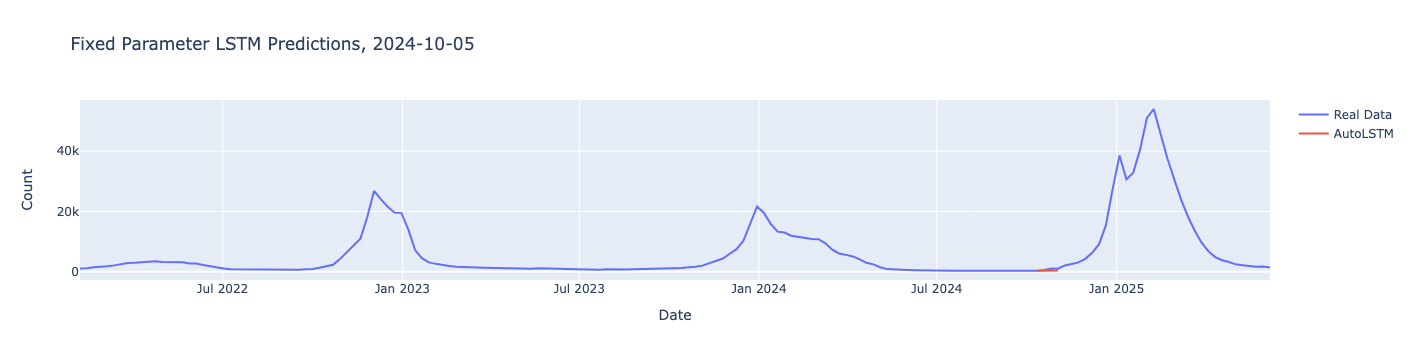

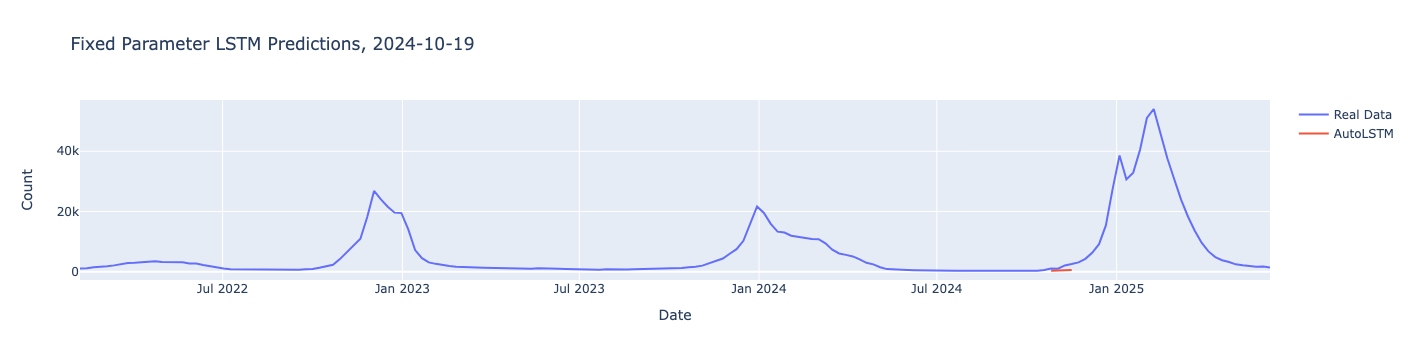

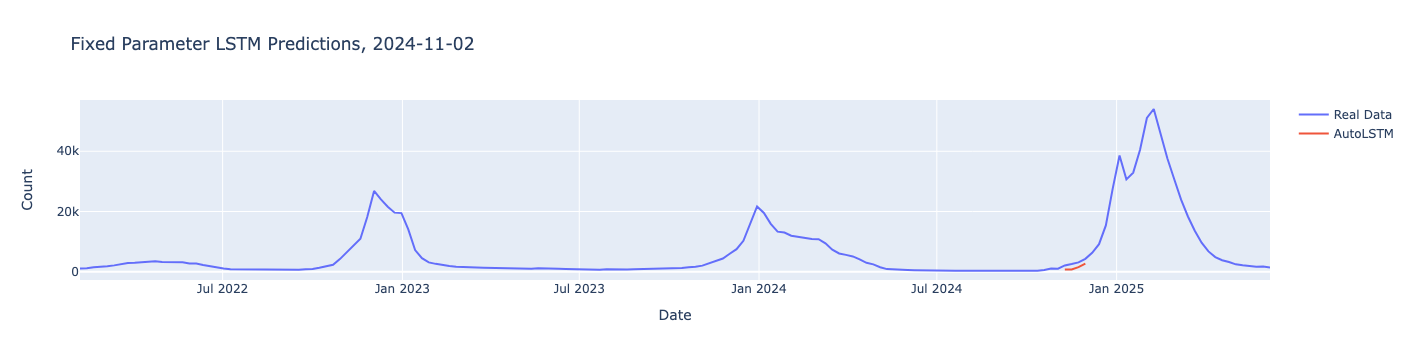

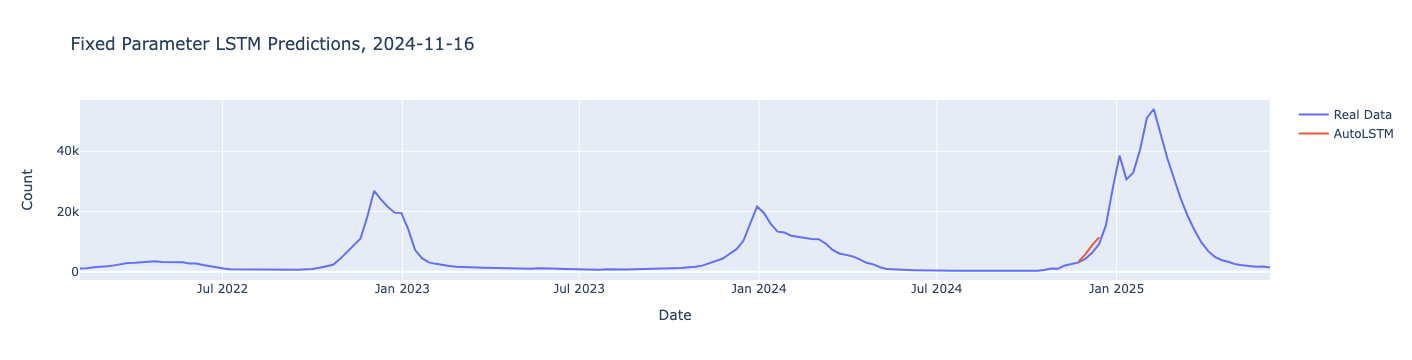

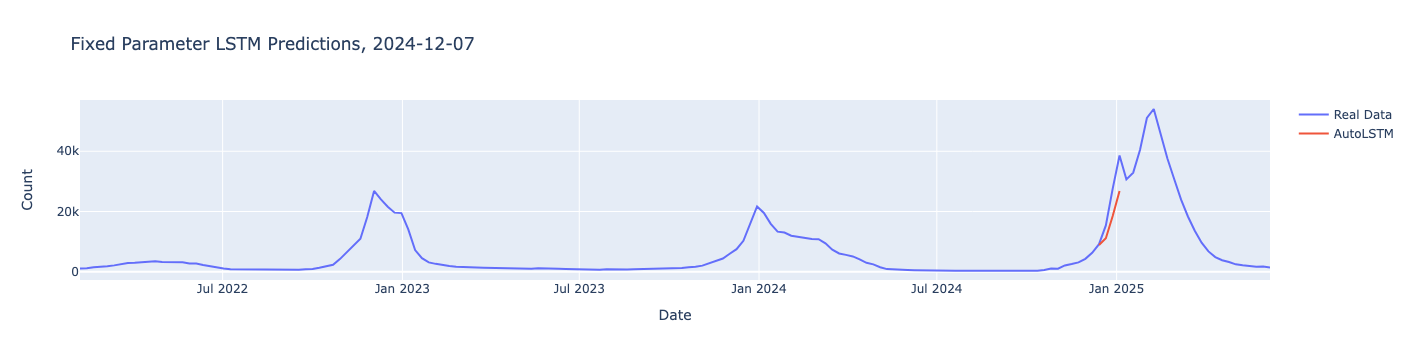

In [31]:
Processor.create_graph()

In [32]:
Processor.color_mapping

{}

In [33]:
Processor.calculate_metrics()

In [34]:
Processor.maes

[399.2720947265625,
 1264.4967803955078,
 1585.4203186035156,
 1640.5911865234375,
 6373.8984375]

In [35]:
Processor.mses

[242713.14663621783,
 1935314.318133046,
 2533696.5770603903,
 3499379.0900219083,
 60284940.78253937]

In [36]:
Processor.mapes

[0.4443831938878886,
 0.7389678764255416,
 0.5641064043680433,
 0.27089613725245076,
 0.23643468210603577]

In [37]:
Processor.create_display_df()

In [38]:
Processor.display_df

,Reference Date,Target End Date,Quantile,Prediction
0,2024-10-05,2024-10-12,0.5,285.137939
1,2024-10-05,2024-10-19,0.5,290.961914
2,2024-10-05,2024-10-26,0.5,330.679443
3,2024-10-05,2024-11-02,0.5,387.132324
4,2024-10-19,2024-10-26,0.5,319.460327
5,2024-10-19,2024-11-02,0.5,333.390686
6,2024-10-19,2024-11-09,0.5,416.234619
7,2024-10-19,2024-11-16,0.5,514.927246
8,2024-11-02,2024-11-09,0.5,700.883057
9,2024-11-02,2024-11-16,0.5,754.911133


In [39]:
Processor.create_metrics_df()

In [40]:
Processor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,399.272095,2.427131e+05,0.444383,2.379280
1,2024-10-19,1264.496780,1.935314e+06,0.738968,4.507994
2,2024-11-02,1585.420319,2.533697e+06,0.564106,3.765590
3,2024-11-16,1640.591187,3.499379e+06,0.270896,0.666191
4,2024-12-07,6373.898438,6.028494e+07,0.236435,0.468299


In [ ]:
Processor2 = FixedModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [ ]:
Processor2.create_training_dfs(value_col="value")

In [ ]:
Processor2.load_fixed_model(path = "AutoLSTM/fixed_models/test_model/")

In [ ]:
Processor2.create_fixed_model(h = 4, freq = "W-SAT", model_name = "test_model", level = [80, 95])

In [ ]:
Processor2.create_display_df()

In [ ]:
Processor.display_df.equals(Processor2.display_df)

In [ ]:
Processor.display_df

In [ ]:
Processor2.display_df

In [ ]:
class UpdatingModelLSTMProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        self.dfs = []
        
        self.nfs = []
        
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Quantile", "Prediction"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
    
    def create_models(self, h, freq, model_names, level = [], config = None):
        if not self.nfs:
            for i in range(len(self.dfs)):
                if not level:
                    nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna", config = config, search_alg = optuna.samplers.TPESample())], freq = freq)
                    nf.fit(df = self.dfs[i])
                else:
                    nf = NeuralForecast(models = [AutoLSTM(h = h, backend = "optuna", loss = MQLoss(level = level), config = config, search_alg = optuna.samplers.TPESampler())], freq = freq)
                    nf.fit(df = self.dfs[i])
                
                self.nfs.append(nf)
                nf.save(path=f'AutoLSTM/updating_models/{model_names[i]}/', overwrite = True)
        
        for i in range(len(self.dfs)):
            y_hat = self.nfs[i].predict(df = self.dfs[i])
            y_hat.set_index("ds", inplace = True)
            y_hat.drop(columns = "unique_id", inplace = True)
            self.forecasts.append(y_hat)

    def load_models(self, paths):
        for i in range(len(paths)):
            nf = NeuralForecast.load(path = paths[i])
            self.nfs.append(nf)
    
        
    def generate_color_map(self, columns, cmap_name = "viridis"):
        intervals = set()
        for col in columns:
            if 'median' in col:
                continue
            parts = col.split('-')
            number = parts[-1]
            intervals.add(number)
        
        intervals = sorted(intervals, key=int)
        cmap = plt.cm.get_cmap(cmap_name)
        
        n = len(intervals)
        if n > 0:
            half = np.linspace(0.2, 0.45, n // 2, endpoint=True)[::-1]  # lower intervals
            upper = np.linspace(0.55, 0.8, n - n // 2, endpoint=True)  # higher intervals
            sample_points = np.concatenate([half, upper])
        else:
            sample_points = np.array([])  # just median
        
        median_value = np.median(sample_points)
        
        color_mapping = {}
        color_mapping['median'] = mcolors.to_hex(cmap(median_value))  # center of the colormap
        for interval, point in zip(intervals, sample_points):
            color_mapping[interval] = mcolors.to_hex(cmap(point))
    
        return color_mapping
    
    def create_graph(self):
        
        #Create color map for various confidence bands, only if levels are present
        if len(self.forecasts[0].columns) != 1:
            self.color_mapping = self.generate_color_map(columns = self.forecasts[0].columns)
                
        
        for i in range(len(self.forecasts)):
            #Plot the overall Real Data
            fig = go.Figure()
            fig.add_trace(go.Scatter(x = self.overall_df.index, y = self.overall_df[self.overall_df_value_col], mode = "lines", name = "Real Data"))

            
            for col in self.forecasts[i].columns:
                #Plot his first
                if "hi" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Lows will go to corresponding his
                if "lo" in col:
                    number = col[-2:]
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             fill = "tonexty", fillcolor = self.color_mapping[number], line = dict(color = self.color_mapping[number])))
            
            for col in self.forecasts[i].columns:
                #Median gets plotted last
                if "median" in col:
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i][col], mode = "lines", name = col, 
                                             line = dict(color = self.color_mapping["median"])))
            
            #Case for if confidence interval not present
            for col in self.forecasts[i].columns:
                if col == "AutoLSTM":
                    fig.add_trace(go.Scatter(x = self.forecasts[i].index, y = self.forecasts[i]["AutoLSTM"], mode = "lines", name = "AutoLSTM"))
            
            
            fig.update_layout(title = f"Updating Parameter LSTM Predictions, {self.dates[i]}", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
            fig.show()
        
        
    def calculate_metrics(self):
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i].iloc[:, 0])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def display_maes(self):
        for i in range(len(self.maes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Error for {english_date} model: {self.maes[i]}")
        
    def display_mses(self):
        for i in range(len(self.mses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Squared Error for {english_date} model: {self.mses[i]}")
    
    def display_mapes(self):
        for i in range(len(self.mapes)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Mean Absolute Percentage Error for {english_date} model: {self.mapes[i]}")
    
    def display_nmses(self):
        for i in range(len(self.nmses)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            print(f"Normalized Mean Square Error for {english_date} model: {self.nmses[i]}")
        
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
    
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                
                for col in self.forecasts[i].columns:
                    value = self.forecasts[i].loc[target_end_date, col]
                    if "lo" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = alpha / 2
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    if col == "AutoLSTM" or "median" in col:
                        quantile = 0.5
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]

                    elif "hi" in col:
                        number = int (col[-2:])
                        alpha = 1 - (number / 100)
                        quantile = 1 - (alpha / 2)
                        self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, quantile, value]
                
        self.display_df.sort_values(by = ["Reference Date", "Target End Date", "Quantile"], inplace = True)
            


In [ ]:
UpdatingProcessor = UpdatingModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [ ]:
UpdatingProcessor.create_training_dfs(value_col = "value")

In [ ]:
UpdatingProcessor.create_models(h = 4, freq = "W-SAT", model_names = ["test_1", "test_2", "test_3", "test_4", "test_5"], level = [80, 95], config = config_LSTM)

In [ ]:
UpdatingProcessor.forecasts[2]

In [ ]:
UpdatingProcessor.create_graph()

In [ ]:
UpdatingProcessor.calculate_metrics()

In [ ]:
UpdatingProcessor.maes

In [ ]:
UpdatingProcessor.create_display_df()

In [ ]:
UpdatingProcessor.display_df

In [ ]:
UpdatingProcessor.create_metrics_df()

In [ ]:
UProcessor2 = UpdatingModelLSTMProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [ ]:
UProcessor2.create_training_dfs(value_col="value")

In [ ]:
model_paths = ["AutoLSTM/updating_models/test_1/", "AutoLSTM/updating_models/test_2/", "AutoLSTM/updating_models/test_3/",
              "AutoLSTM/updating_models/test_4/", "AutoLSTM/updating_models/test_5/"]
UProcessor2.load_models(paths = model_paths)

In [ ]:
UProcessor2.create_models(h = 4, freq = "W-SAT", model_names = ["test_1", "test_2", "test_3", "test_4", "test_5"], level = [80, 95])

In [ ]:
UProcessor2.create_display_df()

In [ ]:
UProcessor2.display_df

In [ ]:
UpdatingProcessor.display_df

In [ ]:
UpdatingProcessor.display_df.equals(UProcessor2.display_df)